# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential 
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, InputLayer
from scikeras.wrappers import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder



# Data loading functions

In [14]:
# Define function to load training data from individual files
def load_training_data(folder_path, count, authors_to_include=[]):
    numbers_list = [num for num in range(1, count+1)]
    data_list = []
    filename_list = []
    iterator = 0
    for filename in os.listdir(folder_path):
        # Check if the filename contains "aggr"
            if "aggr" in filename and "complete" not in filename:
                num = filename.split("_")[2]
                if int(num) in numbers_list:
                    if iterator < count:
                        iterator += 1
                        file_path = os.path.join(folder_path, filename)
                        df = pd.read_csv(file_path, encoding='latin-1')
                        if authors_to_include:
                            df = df[df["Author"].isin(authors_to_include)]
                        # Replace NaN values with 0.0
                        df.fillna(0.0, inplace=True)
                        if df.isnull().values.any():
                            print(f"NaN values found in DataFrame: {filename}")
                            print(df[df.isnull().any(axis=1)])
                        data_list.append(df)
                        filename_list.append(filename)
    return pd.concat(data_list, ignore_index=True)

# Define function to load testing data from a single file
def load_testing_data(folder_path, count, count_adder, authors_to_include=[]):
    numbers_list = [num for num in range(count_adder+1, count_adder+count+1)]
    data_list = []
    filename_list = []
    iterator = 0
    count_iterator = 1
    for filename in os.listdir(folder_path):
        # Check if the filename contains "aggr"
            num = filename.split("_")[2]
            if "aggr" in filename and "complete" not in filename and int(num) in numbers_list:
                count_iterator += 1
                if iterator < count:
                    iterator += 1
                    file_path = os.path.join(folder_path, filename)
                    df = pd.read_csv(file_path, encoding='latin-1')
                    # Replace NaN values with 0.0
                    if authors_to_include:
                        df = df[df["Author"].isin(authors_to_include)]
                    df.fillna(0.0, inplace=True)
                    data_list.append(df)
                    filename_list.append(filename)
    return pd.concat(data_list, ignore_index=True)

def create_complete_data(folder_path, authors_to_include=[]):
    authors_set = set(authors_to_include)
    dfs = []

    for filename in os.listdir(folder_path):
        if "aggr" in filename and "complete" not in filename:
            file_path = os.path.join(folder_path, filename)

            df = pd.read_csv(file_path, encoding='latin-1')

            if authors_to_include:
                df = df[df["Author"].isin(authors_set)]

            if df.isnull().values.any():
                print(f"NaN values found in DataFrame: {filename}")
            df.fillna(0.0, inplace=True)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


# def optimize_dataframe(df):
#     for col in df.select_dtypes(include=["float", "int"]).columns:
#         df[col] = pd.to_numeric(df[col], downcast="float" if df[col].dtype == "float64" else "integer")
#     for col in df.select_dtypes(include=["object"]).columns:
#         if df[col].nunique() < 0.5 * len(df):
#             df[col] = df[col].astype("category")
#     return df

# def create_complete_data(folder_path, authors_to_include=[], chunksize=100):
#     authors_set = set(authors_to_include)
#     dfs = []

#     for filename in os.listdir(folder_path):
#         if "aggr" in filename and "complete" not in filename:
#             file_path = os.path.join(folder_path, filename)
#             chunk_list = []
#             for chunk in pd.read_csv(file_path, encoding='latin-1', chunksize=chunksize):
#                 if authors_to_include:
#                     chunk = chunk[chunk["Author"].isin(authors_set)]

#                 chunk.fillna(0.0, inplace=True)
#                 chunk_list.append(optimize_dataframe(chunk))

#             file_df = pd.concat(chunk_list, ignore_index=True)
#             dfs.append(file_df)

#     combined_df = pd.concat(dfs, ignore_index=True)
#     return combined_df

# Random Forest Model

In [4]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# hyperparameters = {'bootstrap': True, 
#                     'max_depth': None, 
#                     'min_samples_leaf': 2, 
#                     'min_samples_split': 10, 
#                     'n_estimators': 500}

#hyperparameters = {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

hyperparameters = {'bootstrap': False,
             'max_depth': 39,
             'min_samples_leaf': 2,
             'min_samples_split': 2,
             'n_estimators': 631}


rf_model = RandomForestClassifier(**hyperparameters)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)





Accuracy: 0.7464285714285714
Precision: 0.6904554166164073
Recall: 0.7464285714285714
F1-Score: 0.7040888085530942


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


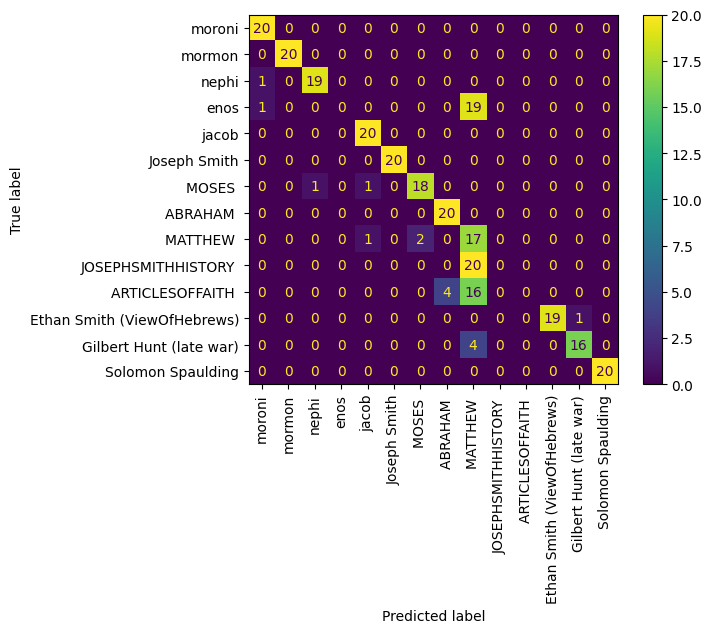

In [5]:
cm = confusion_matrix(y_test, y_pred, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')

## RF Cross Validation

In [6]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=50)

print("Cross-validation scores:", cv_scores)

print("Mean CV score:", np.mean(cv_scores))
print("Standard deviation of CV scores:", np.std(cv_scores))

feature_importances = rf_model.feature_importances_
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df_top5 = importances_df.head(5)
print(importances_df_top5)

Cross-validation scores: [0.73913043 0.69565217 0.69565217 0.65217391 0.69565217 0.56521739
 0.73913043 0.73913043 0.73913043 0.73913043 0.65217391 0.65217391
 0.69565217 0.65217391 0.73913043 0.65217391 0.73913043 0.73913043
 0.56521739 0.73913043 0.77272727 0.81818182 0.81818182 0.81818182
 0.77272727 0.77272727 0.77272727 0.77272727 0.77272727 0.77272727
 0.68181818 0.81818182 0.72727273 0.81818182 0.77272727 0.77272727
 0.86363636 0.77272727 0.72727273 0.77272727 0.77272727 0.77272727
 0.72727273 0.72727273 0.72727273 0.68181818 0.77272727 0.72727273
 0.72727273 0.72727273]
Mean CV score: 0.7356126482213438
Standard deviation of CV scores: 0.05924278867348432
                       Feature  Importance
332           Total_Word_Count    0.067251
333  Total_Function_Word_Count    0.059606
335         AVG_Word_Per_Verse    0.050553
330          Ã¢_percentage_use    0.032666
313           j_percentage_use    0.024848


## RF Grid Search

In [ ]:
param_grid = {
    'n_estimators': [250, 500],
    'max_depth': [5, 15,100, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 5, 7, 10, 15],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best Model: RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, random_state=42)


## RF Bayesian Hyperparameter Search 

In [ ]:
param_space = {
    "n_estimators": Integer(100, 1000),          
    "max_depth": Integer(5, 50),                 
    "min_samples_split": Integer(2, 20),        
    "min_samples_leaf": Integer(1, 10),         
    "bootstrap": Categorical([True, False]),   
}


bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space,
    n_iter=50,  
    cv=5,       
    scoring='accuracy', 
    random_state=42,
    verbose=2
)


bayes_search.fit(X_train, y_train)


print("Best Parameters:", bayes_search.best_params_)

y_pred = bayes_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.5s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.4s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=9, min_samples_split=8, n_estimators=703; total time=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4, min_samples_split=19, n_estimators=878; total time=   4.5s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4, min_samples_split=19, n_estimators=878; total time=   4.7s
[CV] END bootstrap=False, max_depth=45, min_samples_leaf=4,

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 39),
             ('min_samples_leaf', 2),
             ('min_samples_split', 2),
             ('n_estimators', 631)])

# K Neighbors Model

In [9]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)


predictions = knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'
recall = recall_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'
f1 = f1_score(y_test, predictions, average='weighted')  # Other options: 'micro', 'macro'

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.7285714285714285
Precision: 0.6672747755228574
Recall: 0.7285714285714285
F1-Score: 0.6802171216488548


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## K Neighbors Confusion Grid

In [113]:
cm = confusion_matrix(y_test, predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')

ValueError: Found input variables with inconsistent numbers of samples: [160, 280]

# Neural Net Model

## Model Creation

In [76]:
def create_model(X_train, num_authors, structure):
  features_in_data = X_train.shape[1]
  model = Sequential()
  model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
  for i in structure:
    model.add(Dense(i, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
  model.add(Dense(num_authors, activation = 'softmax' ))
  #custom_learning_rate = 0.001
  custom_learning_rate = 0.01
  optimizer = Adam(learning_rate=custom_learning_rate)
  model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
  return model

## Load Data & Run Model

In [12]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
minMaxScaler = MinMaxScaler()
features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [54]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_authors = len(label_encoder.classes_)

optimizer = Adam(learning_rate=0.0009)

structure =[
1024,512
]

model = create_model(X_train, num_authors, structure)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=128, callbacks=[early_stop], shuffle=True)
hist = pd.DataFrame(history.history)

scikit_nn = KerasClassifier(build_fn=create_model(X_train, num_authors, structure), epochs=1000, batch_size=128, callbacks=[early_stop], shuffle=True)

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0974 - loss: 2.5687 - val_accuracy: 0.1778 - val_loss: 2.3727
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2598 - loss: 2.2926 - val_accuracy: 0.4222 - val_loss: 2.0635
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4839 - loss: 1.8941 - val_accuracy: 0.4556 - val_loss: 1.7136
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5387 - loss: 1.5264 - val_accuracy: 0.4333 - val_loss: 1.6076
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5730 - loss: 1.2964 - val_accuracy: 0.5778 - val_loss: 1.3025
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6217 - loss: 1.0706 - val_accuracy: 0.4778 - val_loss: 1.2575
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6502 - loss: 0.8811 - val_accuracy: 0.5444 - val_loss: 1.1783
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6653 - loss: 0.8157 - val_accuracy: 0.5111 - val_loss: 1.18

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
class_names = label_encoder.classes_
label_to_name = dict(zip(range(len(class_names)), class_names))
y_pred = model.predict(X_test)
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
predicted_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))

accuracy = accuracy_score(y_test, predicted_labels)

precision, recall, f1_score_nn, support = precision_recall_fscore_support(y_test, predicted_labels, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_nn)
print("Support:", support)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.6678571428571428
Precision: 0.6946005030167314
Recall: 0.6678571428571428
F1 Score: 0.6346160045945223
Support: None


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


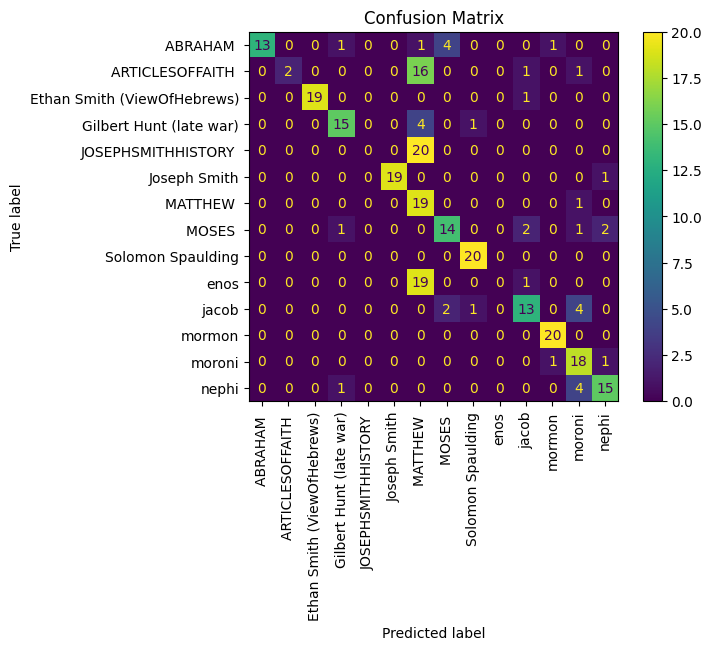

In [56]:

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Xg Boost Regressor Model 

In [ ]:
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_author = encoder.fit_transform(df[['Author']])
encoded_author_df = pd.DataFrame(encoded_author, columns=encoder.get_feature_names_out(['Author']))

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
minMaxScaler = MinMaxScaler()

column_scores = {}
for i in numeric_columns:
    if i == 'Author':
        continue

    target_variable = i
    features = df.drop(columns=[target_variable])
    target = df[target_variable]

    features = pd.concat([features.drop(columns=['Author']), encoded_author_df], axis=1)

    features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)

    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.005, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    n = X_test.shape[0]  
    p = X_test.shape[1]  
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    column_scores[i] = {
        "Mean Squared Error": mse,
        "R-squared": r2,
        "Adjusted R-squared": adjusted_r2,
        "Mean Absolute Error": mae,
        "Mean Absolute Percentage Error": mape
    }

# Print the results
# for column, scores in column_scores.items():
#     print(f"{column}: {scores}")

In [ ]:
r_squared_values = pd.DataFrame([
    {'R-squared': metrics['R-squared']} 
    for metrics in column_scores.values() 
    if metrics['R-squared'] >= 0
])

summary = r_squared_values.describe()

# Count values below 0 before clipping
values_below_zero = (r_squared_values < 0).sum().sum()

# Additional statistics for outliers
z_scores = (r_squared_values - r_squared_values.mean()) / r_squared_values.std()
outliers = r_squared_values[abs(z_scores) > 3].dropna()

# Check for outliers and handle separately if necessary
if not outliers.empty:
    outliers_list = outliers['R-squared'].tolist()
    outliers_summary = pd.DataFrame({'outliers': outliers_list})
else:
    outliers_summary = pd.DataFrame({'outliers': [None]})

# Clip non-numeric values from the summary DataFrame
numeric_summary = numeric_summary.clip(lower=0)
numeric_summary = summary.select_dtypes(include=[float, int])  # Only select numeric columns

# Print the numeric summary
# print("Numeric Summary:")
# print(numeric_summary)

# # Print outliers summary
# print("\nOutliers Summary:")
# print(outliers_summary)

# # Print count of values below 0
# print(f"\nCount of values below 0: {values_below_zero}")

print("Summary statistics:")
print(summary)

# Ensemble Model (NN, K Neighbors, RF)

In [51]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bom_df = create_complete_data(bom_folder_path, authors_to_include=desired_authors)
bible_df = create_complete_data(bible_folder_path)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
latewar_df = create_complete_data(latewar_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)



df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
df = df.fillna(0)
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [75]:
def create_ensemble_model(input_shape, num_authors, structure):
    model = Sequential()
    model.add(InputLayer(shape=(input_shape,)))
    for units in structure:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(num_authors, activation='softmax'))
    optimizer = Adam(learning_rate=0.0009)
    model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)

In [63]:



ensemble_model = VotingClassifier(estimators=[
    ('nn', scikit_nn),
    ('knn', knn),
    ('rf', rf_model)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Predict using the ensemble model
y_pred = ensemble_model.predict(X_test)

# 6. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'
recall = recall_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'
f1 = f1_score(y_test, y_pred, average='weighted')  # Other options: 'micro', 'macro'

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1065 - loss: 2.5522
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4075 - loss: 2.2071
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5712 - loss: 1.8047
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5896 - loss: 1.4702
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6537 - loss: 1.2015
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6578 - loss: 1.0364
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6708 - loss: 0.8685
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7385 - loss: 0.7007
Epoch 9/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7256 - loss: 0.6676
Epoch 10/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7715 - loss: 0.5771
Epoch 11/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7469 - loss: 0.5613
Epoch 12/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7732 - loss: 0.5231
Epoch 13/32
9

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# All Models Run

## Header (define what datasets)

In [15]:
bom_folder_path = "BOM_authors_csv"
bible_folder_path = "Bible_authors_csv"
dc_folder_path = "DC_authors_csv"
pogp_folder_csv = "POGP_authors_csv"
hebrews_folder_path = "hebrews_authors_csv"
latewar_folder_path = "latewar_authors_csv"
spaulding_folder_csv = "SPAULDING_authors_csv"

bom_desired_authors = ["nephi", "jacob", "moroni", "mormon", "enos"]
bible_desired_authors = ["Matthew", "Mark", "Luke", "John", "Paul", "James", "Peter", "Jude", "Unknown(Hebrews)", "John(R)"]
latewar_df = create_complete_data(latewar_folder_path)
bom_df = create_complete_data(bom_folder_path, authors_to_include=bom_desired_authors)
new_df = create_complete_data(bible_folder_path, authors_to_include=bible_desired_authors)
dc_df = create_complete_data(dc_folder_path)
pogp_df = create_complete_data(pogp_folder_csv)
hebrews_df = create_complete_data(hebrews_folder_path)
spaudling_df = create_complete_data(spaulding_folder_csv)


#df = pd.concat([bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df], ignore_index=True)
combos = [
["all", bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df, new_df],
["all_but_new_testament", bom_df, dc_df, pogp_df, hebrews_df, latewar_df, spaudling_df],
["BoM&New", bom_df, new_df],
["BoM&D&C", bom_df, dc_df],
["BoM&D&C&POGP", bom_df, dc_df, pogp_df],
["BoM&POGP", bom_df, pogp_df],
["BoM&Others", bom_df, hebrews_df, latewar_df, spaudling_df],
["D&C&Others", dc_df, hebrews_df, latewar_df, spaudling_df],
["BoM", bom_df],
["New", new_df],

          
          
          
          ]

NaN values found in DataFrame: author_section_46_latewar_aggr.csv
NaN values found in DataFrame: author_section_48_latewar_aggr.csv
NaN values found in DataFrame: author_section_50_latewar_aggr.csv
NaN values found in DataFrame: author_section_52_latewar_aggr.csv
NaN values found in DataFrame: author_section_54_latewar_aggr.csv
NaN values found in DataFrame: author_section_56_latewar_aggr.csv
NaN values found in DataFrame: author_section_58_latewar_aggr.csv
NaN values found in DataFrame: author_section_60_latewar_aggr.csv
NaN values found in DataFrame: author_section_62_latewar_aggr.csv
NaN values found in DataFrame: author_section_64_latewar_aggr.csv
NaN values found in DataFrame: author_section_66_latewar_aggr.csv
NaN values found in DataFrame: author_section_68_latewar_aggr.csv
NaN values found in DataFrame: author_section_70_latewar_aggr.csv
NaN values found in DataFrame: author_section_72_latewar_aggr.csv
NaN values found in DataFrame: author_section_74_latewar_aggr.csv
NaN values

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0777 - loss: 3.0361 - val_accuracy: 0.2500 - val_loss: 2.8533
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2756 - loss: 2.7254 - val_accuracy: 0.3581 - val_loss: 2.3191
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4199 - loss: 2.1076 - val_accuracy: 0.4797 - val_loss: 1.7181
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5531 - loss: 1.4680 - val_accuracy: 0.5405 - val_loss: 1.3970
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5702 - loss: 1.2100 - val_accuracy: 0.5203 - val_loss: 1.3448
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6299 - loss: 0.9877 - val_accuracy: 0.6014 - val_loss: 1.2290
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7123 - loss: 0.8468 - val_accuracy: 0.6419 - val_loss: 1.1530
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7313 - loss: 0.7219 - val_accuracy: 0.6149 

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1002 - loss: 3.0202
Epoch 2/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3181 - loss: 2.6810
Epoch 3/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4725 - loss: 2.1256
Epoch 4/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5726 - loss: 1.5762
Epoch 5/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6522 - loss: 1.2088
Epoch 6/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6888 - loss: 0.9696
Epoch 7/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6968 - loss: 0.8739
Epoch 8/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7378 - loss: 0.7571
Epoch 9/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7630 - loss: 0.6849
Epoch 10/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7501 - loss: 0.6650
Epoch 11/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7892 - loss: 0.5891
Epoch 12/32
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7977 - loss: 0.5628


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


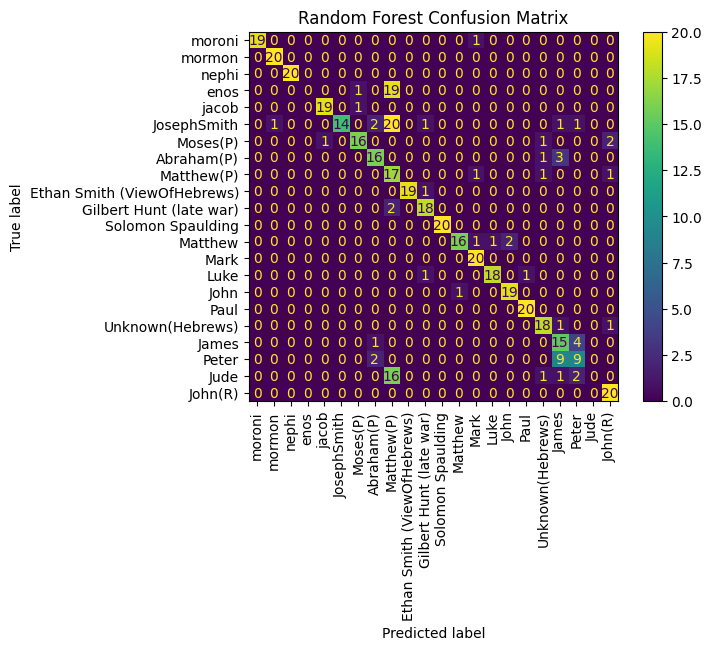

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1128 - loss: 2.4289 - val_accuracy: 0.3333 - val_loss: 2.3697
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3312 - loss: 2.1689 - val_accuracy: 0.5595 - val_loss: 2.0060
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5537 - loss: 1.7118 - val_accuracy: 0.6429 - val_loss: 1.5797
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6648 - loss: 1.2091 - val_accuracy: 0.6786 - val_loss: 1.2340
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7066 - loss: 0.9204 - val_accuracy: 0.6905 - val_loss: 1.0929
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7041 - loss: 0.7564 - val_accuracy: 0.6310 - val_loss: 0.9850
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7505 - loss: 0.5972 - val_accuracy: 0.6190 - val_loss: 0.9541
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7714 - loss: 0.5372 - val_accuracy: 0.5952 - val_loss: 1.05

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1500 - loss: 2.4310
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4467 - loss: 2.1231
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5961 - loss: 1.7085
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6536 - loss: 1.3346
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7024 - loss: 1.0706
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6903 - loss: 0.9181
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7296 - loss: 0.7166
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7855 - loss: 0.6007
Epoch 9/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7874 - loss: 0.5254
Epoch 10/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7697 - loss: 0.5204
Epoch 11/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8148 - loss: 0.4475
Epoch 12/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8262 - loss: 0.4254
Epoch 13/32
9/9 ━━━━━━━━

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


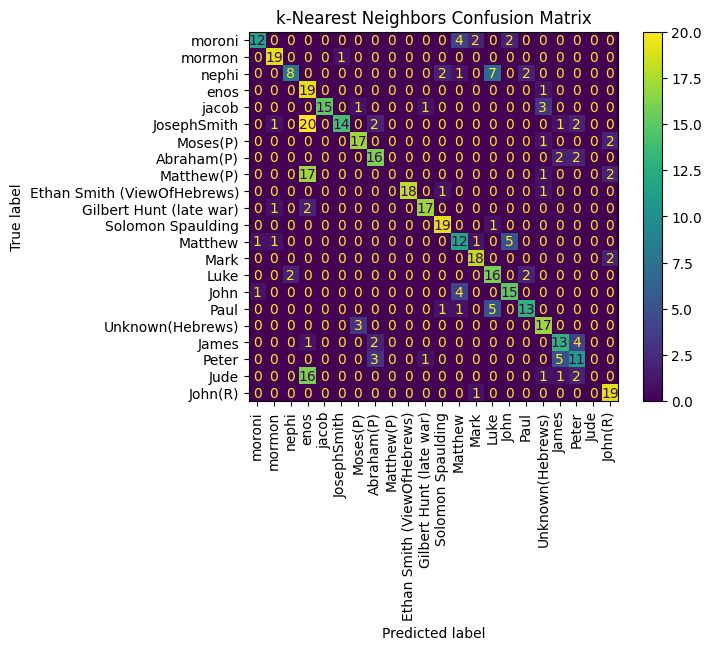

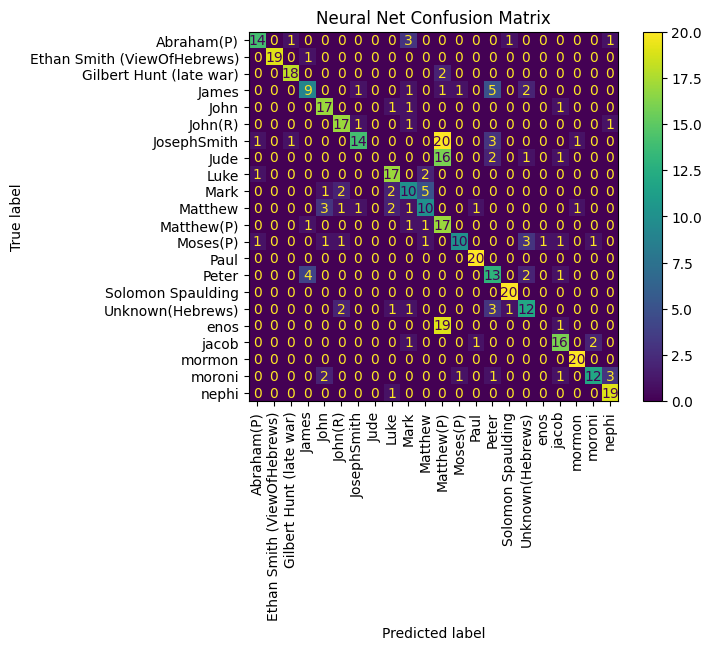

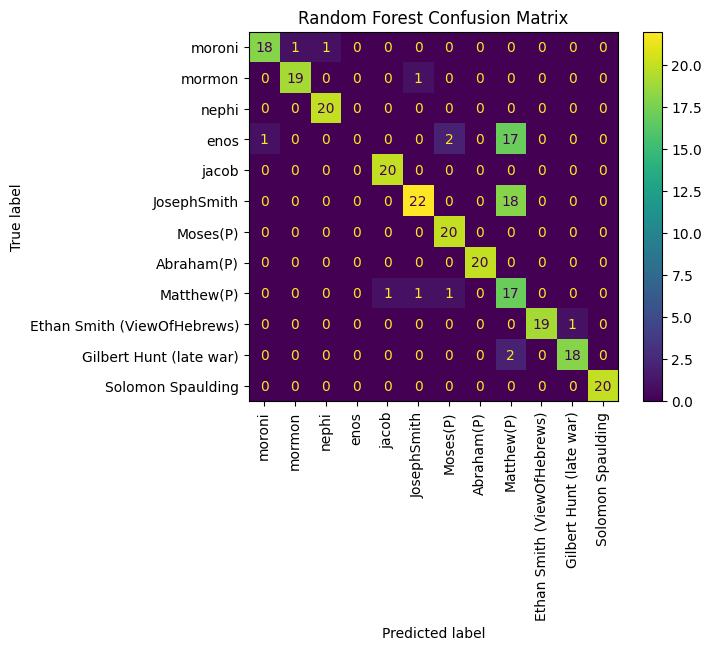

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0994 - loss: 2.6664 - val_accuracy: 0.2812 - val_loss: 2.5414
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3201 - loss: 2.4169 - val_accuracy: 0.3438 - val_loss: 2.2098
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5097 - loss: 1.9293 - val_accuracy: 0.6042 - val_loss: 1.7690
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5641 - loss: 1.4619 - val_accuracy: 0.6250 - val_loss: 1.4132
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6856 - loss: 1.1034 - val_accuracy: 0.5938 - val_loss: 1.2142
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7100 - loss: 0.8946 - val_accuracy: 0.6250 - val_loss: 0.9980
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7970 - loss: 0.6231 - val_accuracy: 0.6458 - val_loss: 0.9709
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7831 - loss: 0.5421 - val_accuracy: 0.6979 - val_loss: 0.83

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


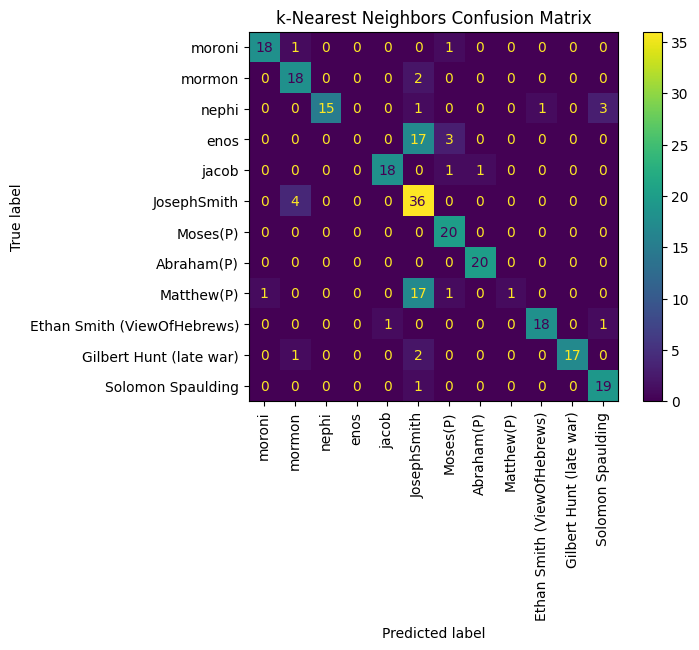

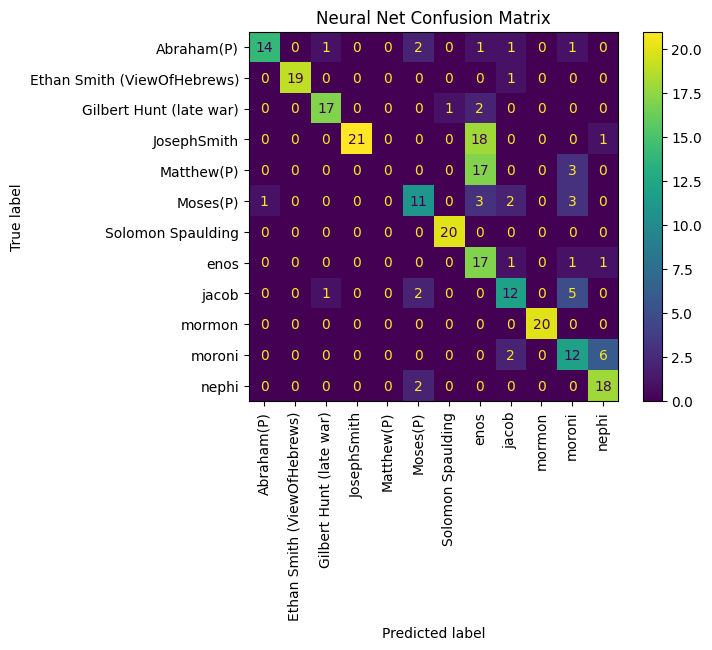

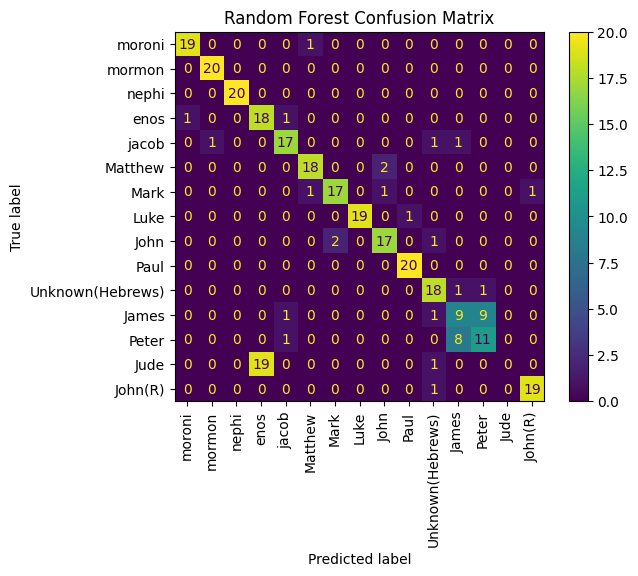

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1792 - loss: 1.7525 - val_accuracy: 0.3846 - val_loss: 1.6299
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4277 - loss: 1.5528 - val_accuracy: 0.6667 - val_loss: 1.4285
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6956 - loss: 1.3212 - val_accuracy: 0.6923 - val_loss: 1.2084
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7714 - loss: 1.0711 - val_accuracy: 0.7949 - val_loss: 1.0121
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8629 - loss: 0.8029 - val_accuracy: 0.8462 - val_loss: 0.8585
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8941 - loss: 0.5833 - val_accuracy: 0.8718 - val_loss: 0.7397
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9180 - loss: 0.4815 - val_accuracy: 0.8205 - val_loss: 0.6473
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9409 - loss: 0.4063 - val_accuracy: 0.8462 - val_loss: 0.56

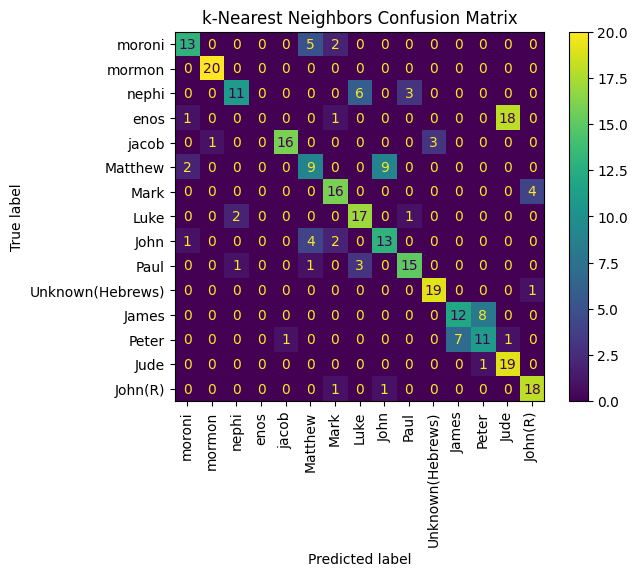

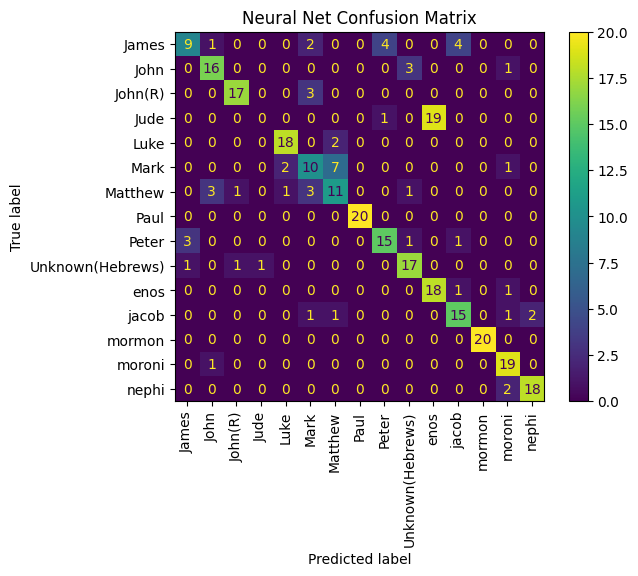

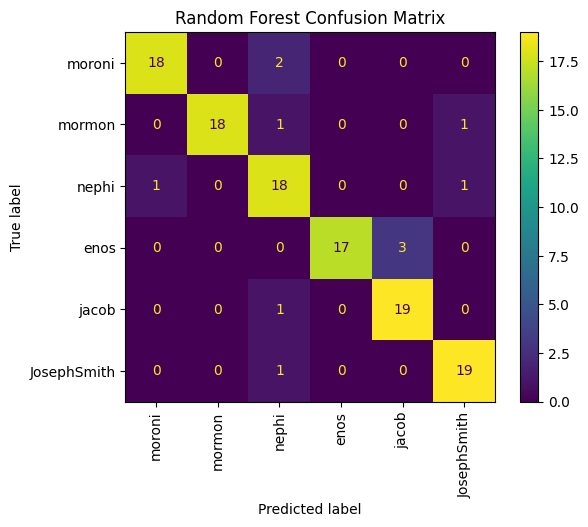

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1726 - loss: 2.1485 - val_accuracy: 0.3438 - val_loss: 2.0253
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3603 - loss: 1.9453 - val_accuracy: 0.5000 - val_loss: 1.8247
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5079 - loss: 1.7126 - val_accuracy: 0.5469 - val_loss: 1.5306
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6385 - loss: 1.3519 - val_accuracy: 0.5312 - val_loss: 1.3646
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6594 - loss: 1.1129 - val_accuracy: 0.5781 - val_loss: 1.2497
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6773 - loss: 0.9217 - val_accuracy: 0.5625 - val_loss: 1.1982
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7238 - loss: 0.7431 - val_accuracy: 0.5469 - val_loss: 1.1622
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7335 - loss: 0.6580 - val_accuracy: 0.5938 - val_loss: 1.03

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1615 - loss: 2.1384  
Epoch 2/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4499 - loss: 1.8732 
Epoch 3/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5530 - loss: 1.6127 
Epoch 4/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6223 - loss: 1.3985 
Epoch 5/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6642 - loss: 1.1565 
Epoch 6/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6927 - loss: 1.0083 
Epoch 7/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6971 - loss: 0.8574 
Epoch 8/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7477 - loss: 0.7141 
Epoch 9/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7237 - loss: 0.6759 
Epoch 10/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7832 - loss: 0.5352 
Epoch 11/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7517 - loss: 0.5138 
Epoch 12/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7791 - loss: 0.4495 
Epoch 13/32

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


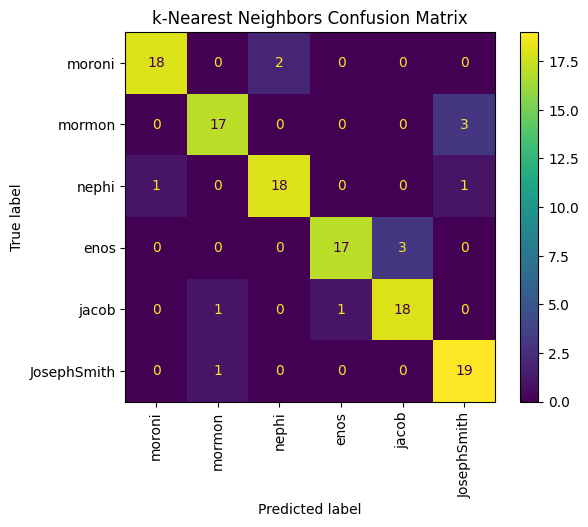

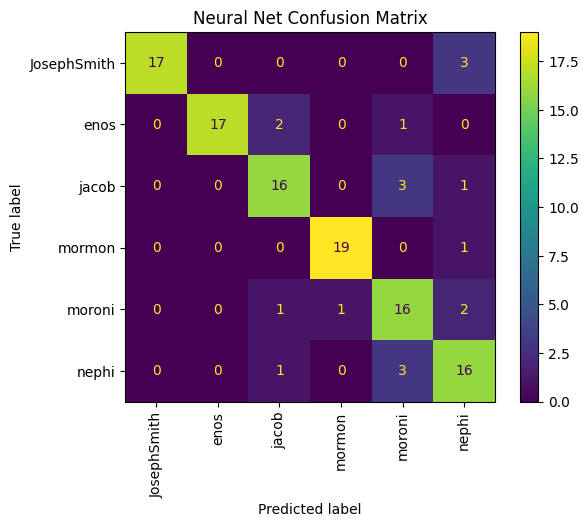

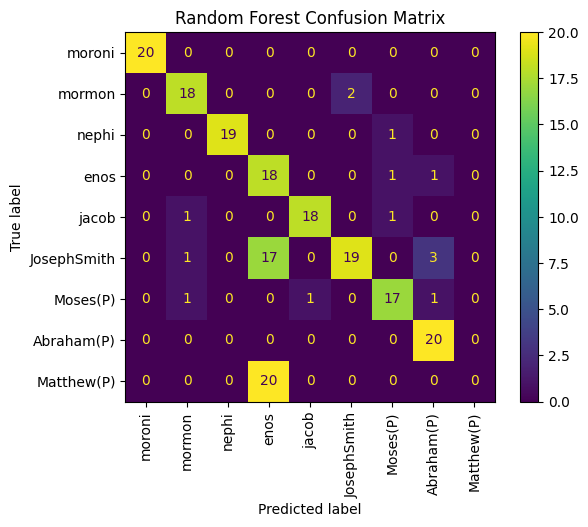

Epoch 1/1000


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1297 - loss: 2.1270 - val_accuracy: 0.3966 - val_loss: 1.9245
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3766 - loss: 1.9180 - val_accuracy: 0.3966 - val_loss: 1.7528
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5007 - loss: 1.7097 - val_accuracy: 0.5690 - val_loss: 1.5023
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6010 - loss: 1.4282 - val_accuracy: 0.6207 - val_loss: 1.3083
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6181 - loss: 1.2262 - val_accuracy: 0.6207 - val_loss: 1.1774
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6325 - loss: 1.0461 - val_accuracy: 0.6552 - val_loss: 1.0156
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6722 - loss: 0.8730 - val_accuracy: 0.6552 - val_loss: 0.8551
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7240 - loss: 0.6878 - val_accuracy: 0.6379 - val_loss: 0.82

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1576 - loss: 2.1169  
Epoch 2/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3795 - loss: 1.8473 
Epoch 3/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5378 - loss: 1.6607 
Epoch 4/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5879 - loss: 1.4047 
Epoch 5/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6437 - loss: 1.2236 
Epoch 6/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6603 - loss: 1.0628 
Epoch 7/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7119 - loss: 0.9190 
Epoch 8/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7345 - loss: 0.7997 
Epoch 9/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7480 - loss: 0.6746 
Epoch 10/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7639 - loss: 0.5889
Epoch 11/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7836 - loss: 0.5110 
Epoch 12/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7565 - loss: 0.4865 
Epoch 13/32

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


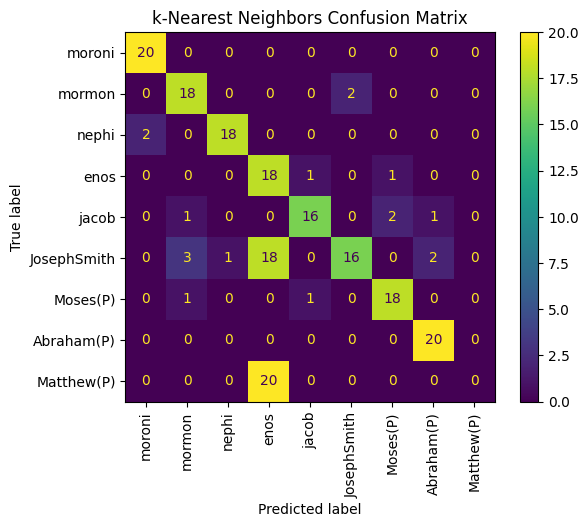

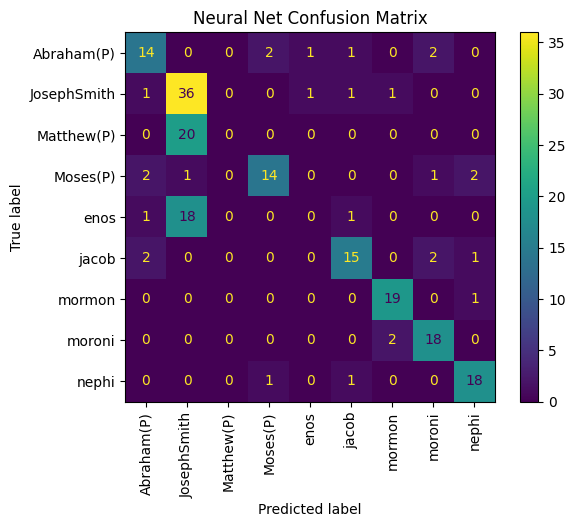

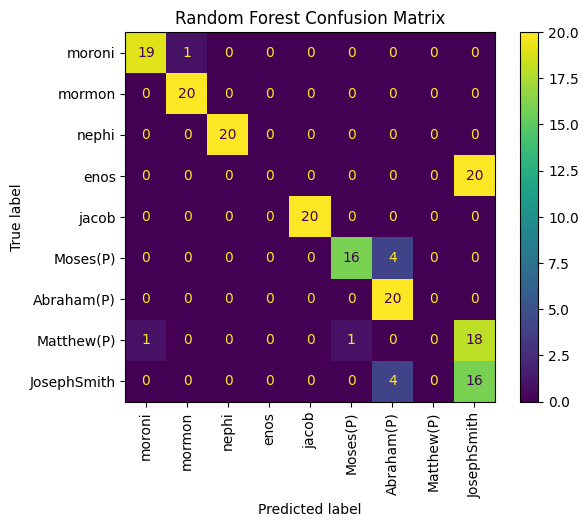

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1960 - loss: 2.0304 - val_accuracy: 0.2885 - val_loss: 1.8356
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4220 - loss: 1.7821 - val_accuracy: 0.6538 - val_loss: 1.4369
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7235 - loss: 1.3532 - val_accuracy: 0.6923 - val_loss: 1.0051
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7628 - loss: 0.9416 - val_accuracy: 0.8269 - val_loss: 0.7159
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8291 - loss: 0.7247 - val_accuracy: 0.8269 - val_loss: 0.5936
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8577 - loss: 0.5578 - val_accuracy: 0.8462 - val_loss: 0.4876
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8878 - loss: 0.4035 - val_accuracy: 0.8269 - val_loss: 0.4419
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9161 - loss: 0.2991 - val_accuracy: 0.8846 - val_loss: 0.39

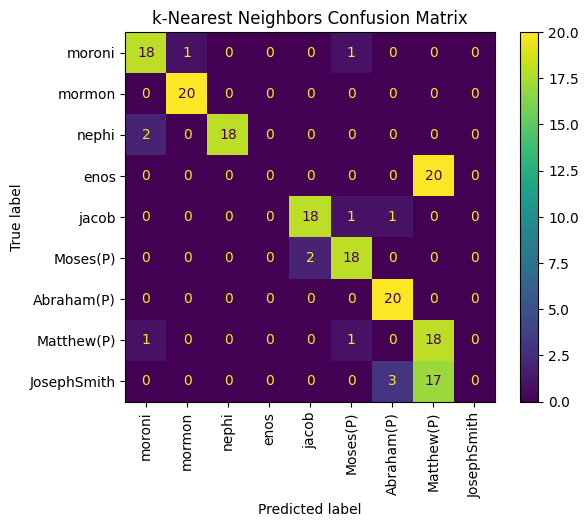

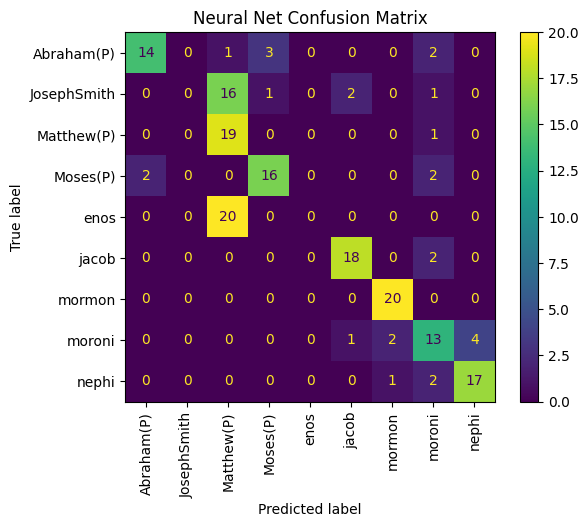

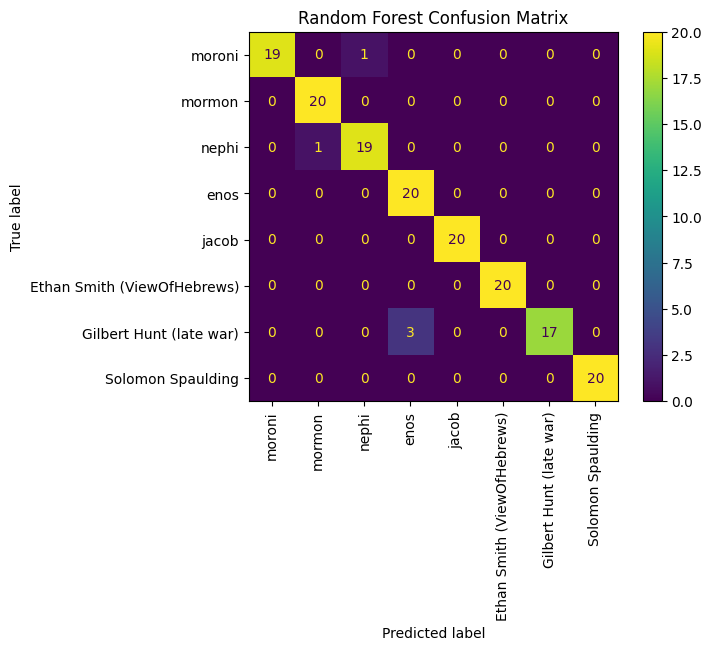

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3462 - loss: 1.3473 - val_accuracy: 0.8462 - val_loss: 1.0657
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8609 - loss: 1.0345 - val_accuracy: 0.9231 - val_loss: 0.6918
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9291 - loss: 0.6182 - val_accuracy: 0.9615 - val_loss: 0.3852
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9581 - loss: 0.3206 - val_accuracy: 1.0000 - val_loss: 0.2259
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9737 - loss: 0.1865 - val_accuracy: 1.0000 - val_loss: 0.1125
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9834 - loss: 0.0996 - val_accuracy: 1.0000 - val_loss: 0.0666
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9946 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.0554
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 1.0000 - val_loss: 0.04

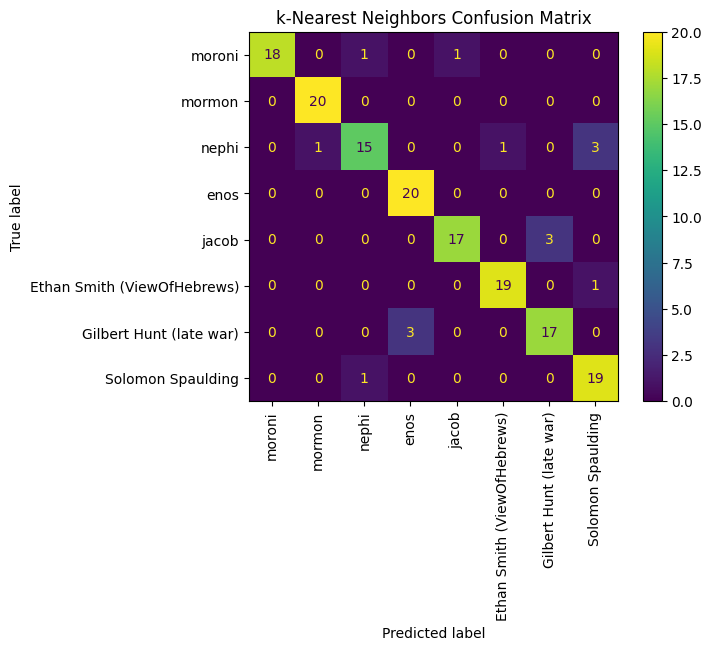

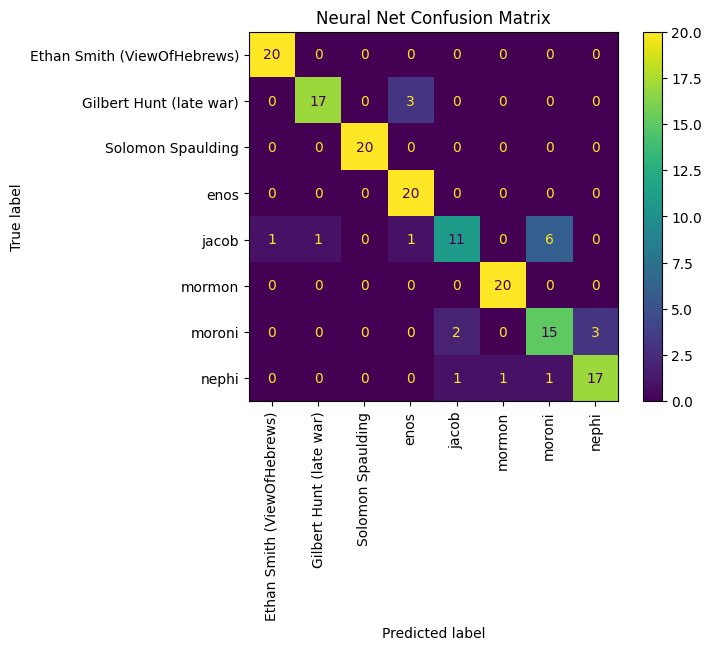

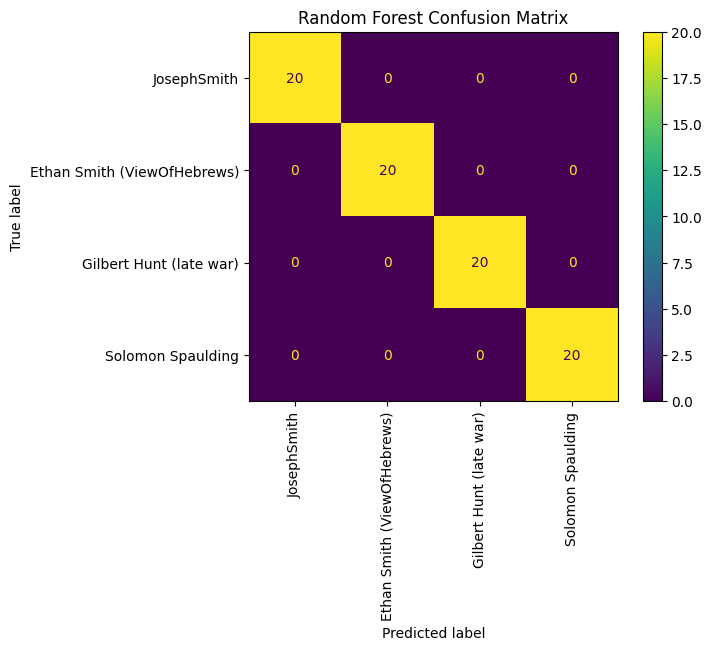

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3462 - loss: 1.5528 - val_accuracy: 0.4375 - val_loss: 1.4084
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4603 - loss: 1.3603 - val_accuracy: 0.8125 - val_loss: 1.2461
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7615 - loss: 1.1904 - val_accuracy: 0.8750 - val_loss: 1.0551
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7993 - loss: 0.9707 - val_accuracy: 0.8750 - val_loss: 0.8842
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8744 - loss: 0.7850 - val_accuracy: 0.8750 - val_loss: 0.7927
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8978 - loss: 0.6398 - val_accuracy: 0.8438 - val_loss: 0.6864
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9340 - loss: 0.4877 - val_accuracy: 0.8750 - val_loss: 0.6534
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9435 - loss: 0.4232 - val_accuracy: 0.8125 - val_loss: 0.56

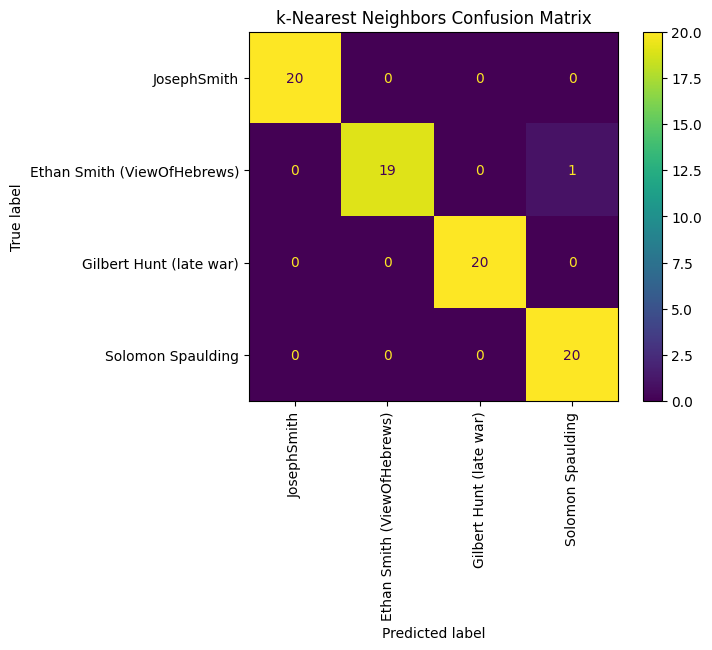

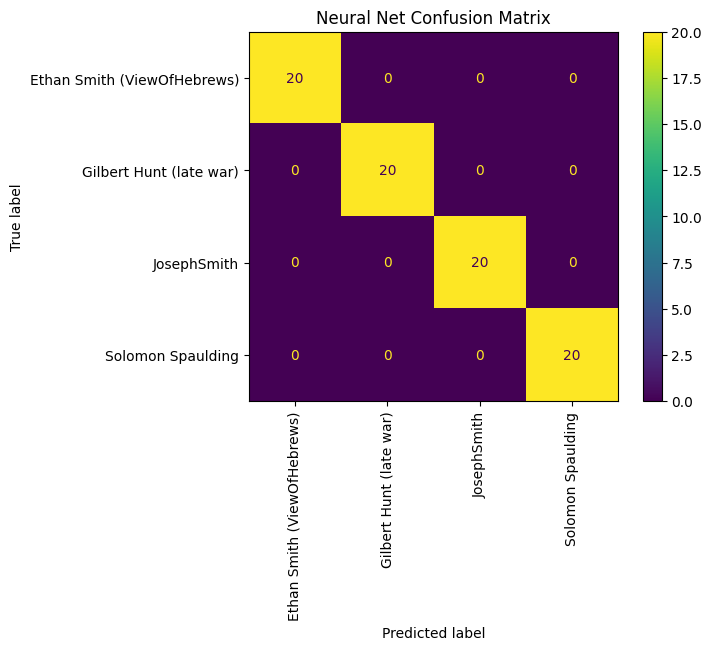

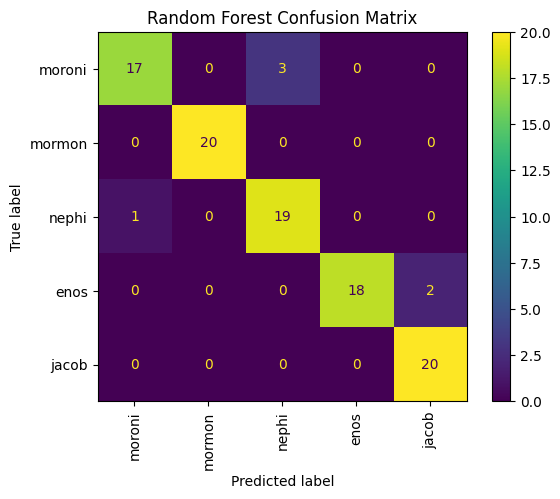

Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1345 - loss: 2.2612 - val_accuracy: 0.2969 - val_loss: 2.1035
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3882 - loss: 2.0642 - val_accuracy: 0.6562 - val_loss: 1.7928
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5921 - loss: 1.7203 - val_accuracy: 0.7031 - val_loss: 1.3764
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7047 - loss: 1.2737 - val_accuracy: 0.6875 - val_loss: 1.0858
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7168 - loss: 0.9663 - val_accuracy: 0.7500 - val_loss: 0.8968
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7798 - loss: 0.7739 - val_accuracy: 0.7344 - val_loss: 0.8304
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7922 - loss: 0.6589 - val_accuracy: 0.7812 - val_loss: 0.7602
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8360 - loss: 0.4880 - val_accuracy: 0.7812 - val_loss: 0.66

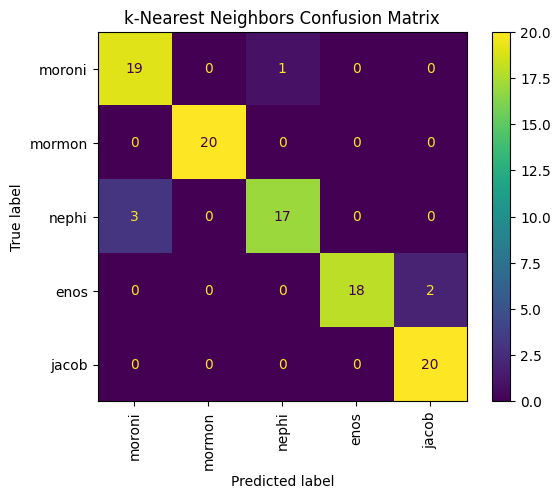

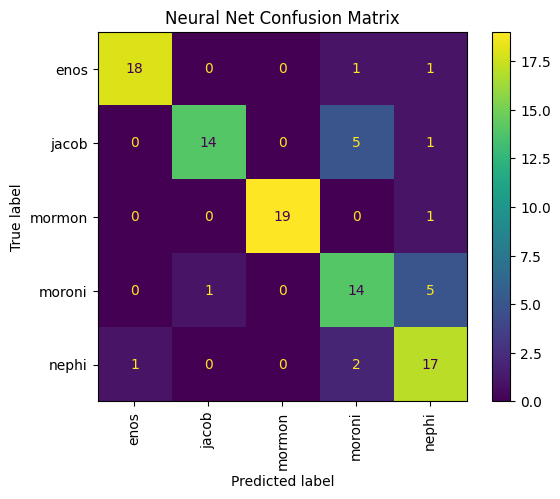

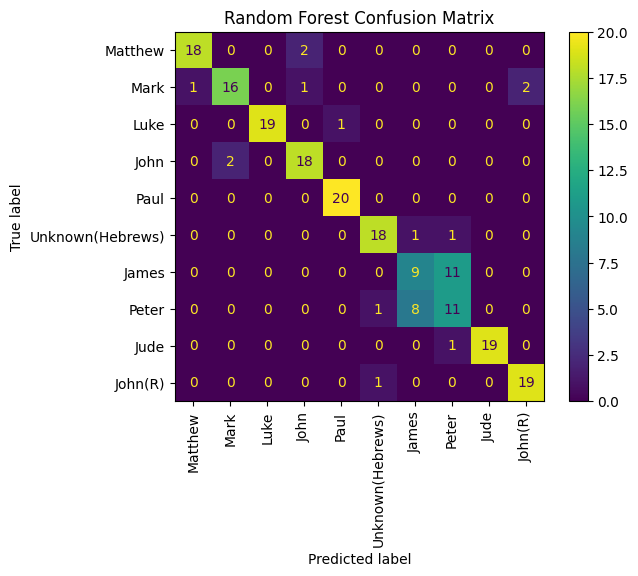

Metrics saved to metrics_report.xlsx


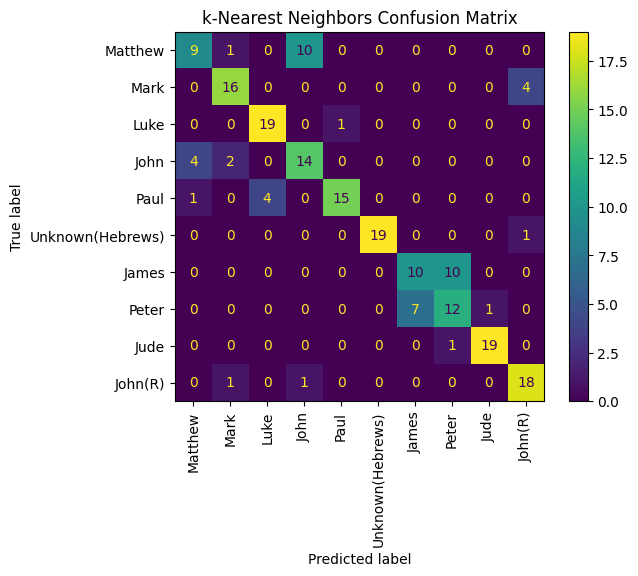

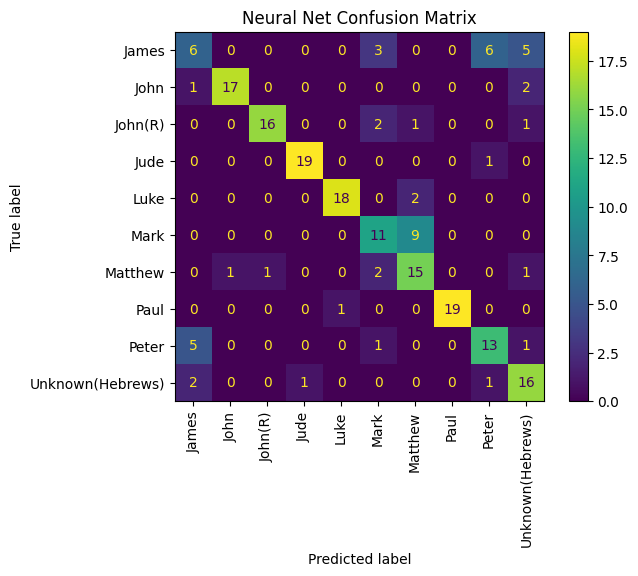

In [16]:
import shutil
excel_data = {}
for i in combos:
    folder_path = f"{i[0]}"
    if os.path.exists(f'Graphs\\{folder_path}'):
        shutil.rmtree(f"Graphs\\{folder_path}")
        os.makedirs(f'Graphs\\{folder_path}')
    else:
        os.makedirs(f'Graphs\\{folder_path}')
    
    df = pd.concat(i[1:], ignore_index=True)
    df = df.fillna(0)

    target = df["Author"]
    features = df.drop(columns=["Author"])
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)


    hyperparameters = {'bootstrap': False,
                'max_depth': 39,
                'min_samples_leaf': 2,
                'min_samples_split': 2,
                'n_estimators': 631}


    rf_model = RandomForestClassifier(**hyperparameters)

    rf_model.fit(X_train, y_train)

    rf_y_pred = rf_model.predict(X_test)

    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_precision = precision_score(y_test, rf_y_pred, average='weighted') 
    rf_recall = recall_score(y_test, rf_y_pred, average='weighted')  
    rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')  
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    knn = KNeighborsClassifier(n_neighbors=10)

    knn.fit(X_train, y_train)


    k_predictions = knn.predict(X_test)

    k_accuracy = accuracy_score(y_test, k_predictions)
    k_precision = precision_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    k_recall = recall_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    k_f1 = f1_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    def create_model(X_train, num_authors, structure):
        features_in_data = X_train.shape[1]
        model = Sequential()
        model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
        for i in structure:
            model.add(Dense(i, activation='relu'))
            model.add(Dropout(0.3))
            #model.add(BatchNormalization())
        model.add(Dense(num_authors, activation = 'softmax' ))
        #custom_learning_rate = 0.001
        custom_learning_rate = 0.01
        optimizer = Adam(learning_rate=custom_learning_rate)
        model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
        return model


    features = df.drop(columns=["Author"])
    minMaxScaler = MinMaxScaler()
    features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    num_authors = len(label_encoder.classes_)

    optimizer = Adam(learning_rate=0.0009)

    structure =[
    1024,512
    ]

    model = create_model(X_train, num_authors, structure)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
    history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=128, callbacks=[early_stop], shuffle=True)
    hist = pd.DataFrame(history.history)

    class_names = label_encoder.classes_
    label_to_name = dict(zip(range(len(class_names)), class_names))
    n_y_pred = model.predict(X_test)
    all_labels = pd.concat([y_train, y_test], axis=0)
    label_encoder.fit(all_labels)
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    n_predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))

    n_accuracy = accuracy_score(y_test, n_predicted_labels)

    n_precision, n_recall, n_f1_score_nn, N_support = precision_recall_fscore_support(y_test, n_predicted_labels, average='weighted')
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    def create_ensemble_model(input_shape, num_authors, structure):
        model = Sequential()
        model.add(InputLayer(shape=(input_shape,)))
        for units in structure:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(0.3))
        model.add(Dense(num_authors, activation='softmax'))
        optimizer = Adam(learning_rate=0.0009)
        model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)


    ensemble_model = VotingClassifier(estimators=[
        ('nn', scikit_nn),
        ('knn', knn),
        ('rf', rf_model)
    ], voting='hard')

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)

    # 5. Predict using the ensemble model
    e_y_pred = ensemble_model.predict(X_test)

    # 6. Evaluate the model
    e_accuracy = accuracy_score(y_test, e_y_pred)
    e_precision = precision_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    e_recall = recall_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    e_f1 = f1_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    metrics = {
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1],
    "KNN": [k_accuracy, k_precision, k_recall, k_f1],
    "Neural Net": [n_accuracy, n_precision, n_recall, n_f1_score_nn],
    "Ensemble Model": [e_accuracy, e_precision, e_recall, e_f1]
    } 
    excel_data[folder_path] = metrics
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################

    cm = confusion_matrix(y_test, rf_y_pred, labels=target.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("Random Forest Confusion Matrix")

    plt.savefig(f"Graphs\\{folder_path}\\rf.png")

    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    plt.show()
    cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("k-Nearest Neighbors Confusion Matrix")


    plt.savefig(f"Graphs\\{folder_path}\\knn.png")


    ######################################################################################################################################################################
    ######################################################################################################################################################################
    ######################################################################################################################################################################
    all_labels = pd.concat([y_train, y_test], axis=0)
    label_encoder.fit(all_labels)


    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)


    predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



    cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title("Neural Net Confusion Matrix")

    plt.savefig(f"Graphs\\{folder_path}\\NN.png")

df_data = []

# Create a list of the column titles (combos)
columns = list(excel_data.keys())

# Populate the rows for each model
for model in metrics.keys():
    # Gather the metrics for the current model across all combos
    row = []
    for folder_path in columns:
        # Get the metrics for the model in the current folder_path combo
        values = excel_data[folder_path].get(model)
        
        # Format the metrics as required, separated by new lines
        metric_string = '\n'.join([f"{metric_name}: {value:.4f}" 
                                  for metric_name, value in zip(['Accuracy', 'Precision', 'Recall', 'F1-Score'], values)])
        
        row.append(metric_string)
    
    # Append the row data for the model
    df_data.append(row)

# Create a DataFrame from the data
df = pd.DataFrame(df_data, index=metrics.keys(), columns=columns)

# Export to Excel

excel_filename = f"metrics_report.xlsx"  # Save file in the current directory or specify path
if os.path.exists(f'{excel_filename}'):
    os.remove(excel_filename)

df.to_excel(excel_filename, index=True)

print(f"Metrics saved to {excel_filename}")


## Model runs

In [17]:
target = df["Author"]
features = df.drop(columns=["Author"])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)


hyperparameters = {'bootstrap': False,
             'max_depth': 39,
             'min_samples_leaf': 2,
             'min_samples_split': 2,
             'n_estimators': 631}


rf_model = RandomForestClassifier(**hyperparameters)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='weighted') 
rf_recall = recall_score(y_test, rf_y_pred, average='weighted')  
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')  

KeyError: 'Author'

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)


k_predictions = knn.predict(X_test)

k_accuracy = accuracy_score(y_test, k_predictions)
k_precision = precision_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
k_recall = recall_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'
k_f1 = f1_score(y_test, k_predictions, average='weighted')  # Other options: 'micro', 'macro'

In [ ]:
def create_model(X_train, num_authors, structure):
  features_in_data = X_train.shape[1]
  model = Sequential()
  model.add(Dense(features_in_data, input_dim=features_in_data, activation='relu'))
  for i in structure:
    model.add(Dense(i, activation='relu'))
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
  model.add(Dense(num_authors, activation = 'softmax' ))
  #custom_learning_rate = 0.001
  custom_learning_rate = 0.01
  optimizer = Adam(learning_rate=custom_learning_rate)
  model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics = ['accuracy'])
  return model


features = df.drop(columns=["Author"])
minMaxScaler = MinMaxScaler()
features_scaled = pd.DataFrame(minMaxScaler.fit_transform(features), columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_authors = len(label_encoder.classes_)

optimizer = Adam(learning_rate=0.0009)

structure =[
1024,512
]

model = create_model(X_train, num_authors, structure)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
history = model.fit(X_train, y_train_encoded, epochs=1000, validation_split=0.08, batch_size=128, callbacks=[early_stop], shuffle=True)
hist = pd.DataFrame(history.history)

class_names = label_encoder.classes_
label_to_name = dict(zip(range(len(class_names)), class_names))
n_y_pred = model.predict(X_test)
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
n_predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))

n_accuracy = accuracy_score(y_test, n_predicted_labels)

n_precision, n_recall, n_f1_score_nn, N_support = precision_recall_fscore_support(y_test, n_predicted_labels, average='weighted')


Epoch 1/1000


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3012 - loss: 1.3459 - val_accuracy: 0.6154 - val_loss: 0.9982
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5684 - loss: 1.0269 - val_accuracy: 0.8846 - val_loss: 0.6442
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9094 - loss: 0.6758 - val_accuracy: 0.8846 - val_loss: 0.4684
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9104 - loss: 0.3912 - val_accuracy: 0.9231 - val_loss: 0.2253
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9535 - loss: 0.2390 - val_accuracy: 0.9615 - val_loss: 0.1745
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9515 - loss: 0.1536 - val_accuracy: 1.0000 - val_loss: 0.0898
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9525 - loss: 0.1284 - val_accuracy: 0.9615 - val_loss: 0.0826
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9800 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 0.04

In [ ]:
def create_ensemble_model(input_shape, num_authors, structure):
    model = Sequential()
    model.add(InputLayer(shape=(input_shape,)))
    for units in structure:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(num_authors, activation='softmax'))
    optimizer = Adam(learning_rate=0.0009)
    model.compile(loss='crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

scikit_nn = KerasClassifier(model=create_ensemble_model, input_shape=X_train.shape[1], num_authors=num_authors, structure=[1024, 512], epochs=32, batch_size=128)


ensemble_model = VotingClassifier(estimators=[
    ('nn', scikit_nn),
    ('knn', knn),
    ('rf', rf_model)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# 5. Predict using the ensemble model
e_y_pred = ensemble_model.predict(X_test)

# 6. Evaluate the model
e_accuracy = accuracy_score(y_test, e_y_pred)
e_precision = precision_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
e_recall = recall_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'
e_f1 = f1_score(y_test, e_y_pred, average='weighted')  # Other options: 'micro', 'macro'


Epoch 1/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3488 - loss: 1.3267  
Epoch 2/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7488 - loss: 0.9444 
Epoch 3/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9246 - loss: 0.5948 
Epoch 4/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9131 - loss: 0.4034 
Epoch 5/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9502 - loss: 0.2627 
Epoch 6/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9711 - loss: 0.1634 
Epoch 7/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.1148 
Epoch 8/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9859 - loss: 0.0960 
Epoch 9/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0595 
Epoch 10/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0452 
Epoch 11/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0401 
Epoch 12/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0291 


In [ ]:
# import os
import pandas as pd

# filename = "metrics_report.txt"

# with open(filename, "w") as file:
#     file.write(f"{folder_path}")

#     file.write("Random Forest\n")
#     file.write(f"Accuracy: {rf_accuracy}\n")
#     file.write(f"Precision: {rf_precision}\n")
#     file.write(f"Recall: {rf_recall}\n")
#     file.write(f"F1 Score: {rf_f1}\n\n")
    
#     file.write("KNN\n")
#     file.write(f"Accuracy: {k_accuracy}\n")
#     file.write(f"Precision: {k_precision}\n")
#     file.write(f"Recall: {k_recall}\n")
#     file.write(f"F1 Score: {k_f1}\n\n")
    
#     file.write("Neural Net\n")
#     file.write(f"Accuracy: {n_accuracy}\n")
#     file.write(f"Precision: {n_precision}\n")
#     file.write(f"Recall: {n_recall}\n")
#     file.write(f"F1 Score: {f1_score_nn}\n\n")
    
#     file.write("Ensemble Model\n")
#     file.write(f"Accuracy: {e_accuracy}\n")
#     file.write(f"Precision: {e_precision}\n")
#     file.write(f"Recall: {e_recall}\n")
#     file.write(f"F1-Score: {e_f1}\n")



# Metrics for each model
metrics = {
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1],
    "KNN": [k_accuracy, k_precision, k_recall, k_f1],
    "Neural Net": [n_accuracy, n_precision, n_recall, f1_score_nn],
    "Ensemble Model": [e_accuracy, e_precision, e_recall, e_f1]
}

# Create a DataFrame where each row contains metrics for a specific model
data = {}
for model, values in metrics.items():
    # Join metrics into a single string separated by newlines
    data[model] = '\n'.join(f"{metric:.4f}" for metric in values)

# Convert to DataFrame (rows = model names, columns = folder_path)
df = pd.DataFrame.from_dict(data, orient='index', columns=[folder_path])

# Export to Excel
excel_filename = f"{folder_path}metrics_report.xlsx"
df.to_excel(excel_filename, index=True)
print(f"Metrics saved to {excel_filename}")

ModuleNotFoundError: No module named 'openpyxl'

NameError: name 'folder_path' is not defined

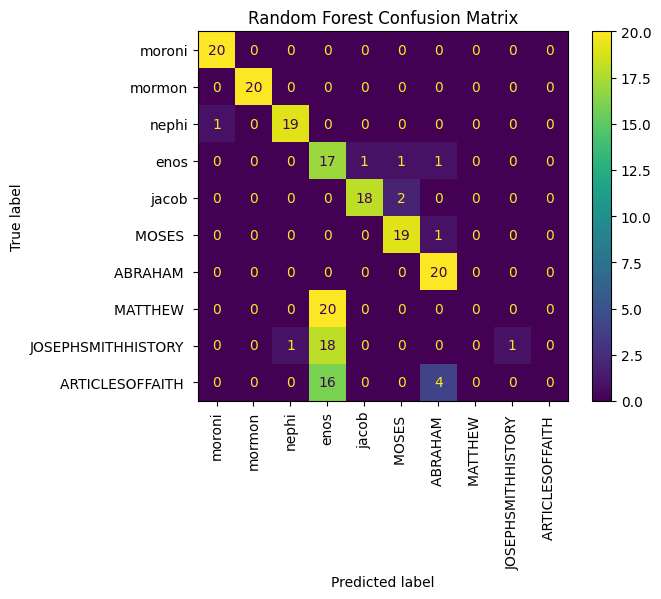

In [ ]:
cm = confusion_matrix(y_test, rf_y_pred, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Random Forest Confusion Matrix")

plt.savefig(f"{folder_path}\rf.png")


plt.show()
cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("k-Nearest Neighbors Confusion Matrix")


plt.savefig(f"{folder_path}\knn.png")

plt.show()

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()

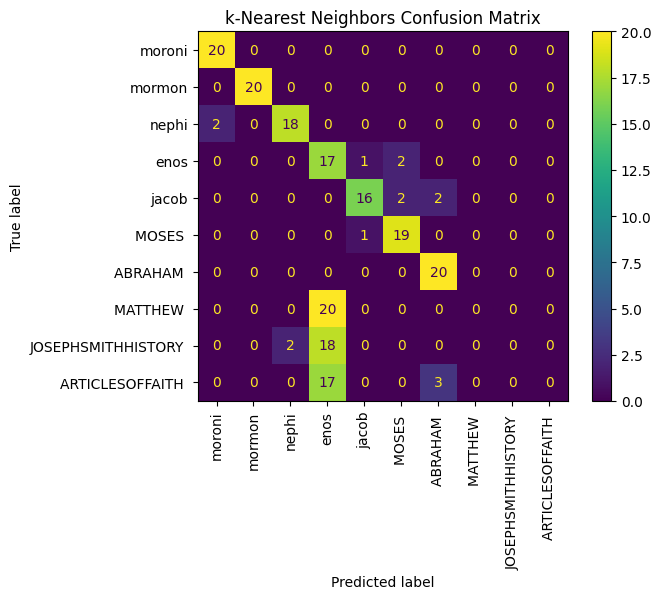

In [ ]:
cm = confusion_matrix(y_test, k_predictions, labels=target.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target.unique())
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("k-Nearest Neighbors Confusion Matrix")


plt.savefig(f"{folder_path}\knn.png")

plt.show()

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()

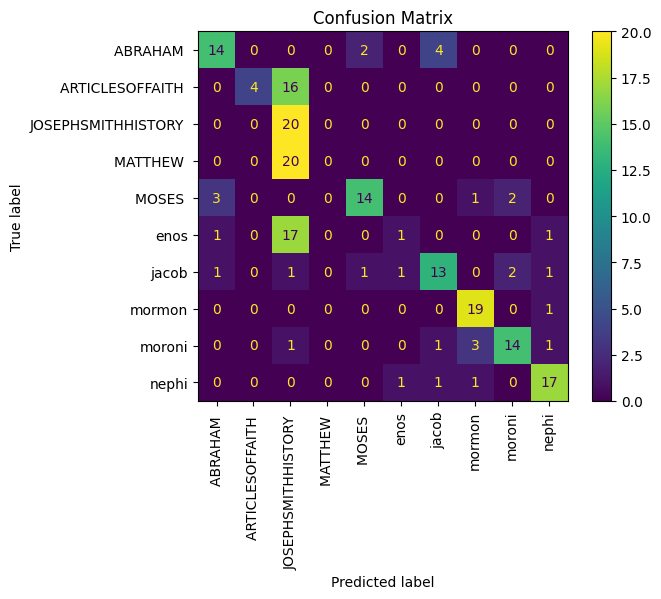

In [ ]:

all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder.fit(all_labels)


y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


predicted_labels = label_encoder.inverse_transform(n_y_pred.argmax(axis=1))



cm = confusion_matrix(y_test, predicted_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Neural Net Confusion Matrix")

plt.savefig(f"{folder_path}\NN.png")


plt.show()